In [27]:
import numpy as np
import timeit

import torch
from matplotlib import pyplot as plt
import seaborn as sns

from lora import LowRankLinearAdapter, LowRankSequential
from utils.params import count_params, count_trainable_params

In [35]:
linear = torch.nn.Linear(28 * 28, 128)
print(f"Total params: {count_params(linear)}, trainable params: {count_trainable_params(linear)}")

Total params: 100480, trainable params: 100480


In [38]:
lora_linear = LowRankLinearAdapter(linear, rank=2)

# re-initialize B to random values rather than all zeros
lora_linear._lora._reinit_B(lambda r, d: torch.randn((r, d)))
print(f"Total params: {count_params(lora_linear)}, trainable params: {count_trainable_params(lora_linear)}")

Total params: 102304, trainable params: 1952


In [4]:
samaple_input = torch.randn(10).unsqueeze(0)

In [5]:
unmerged_output = lora_linear(samaple_input).log_softmax(dim=-1).exp().detach()

lora_linear.merge_weights()
merged_output = lora_linear(samaple_input).log_softmax(dim=-1).exp().detach()

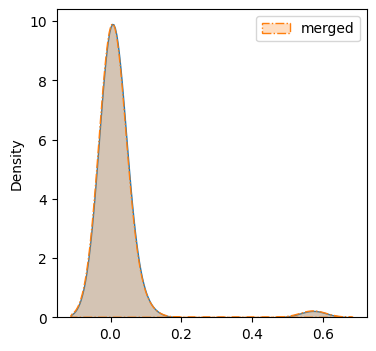

In [6]:
plt.figure(figsize=(4, 4))
sns.kdeplot(unmerged_output.flatten(), fill=True)
# plot with spaced out dashes, more spaced out than with "--"
sns.kdeplot(merged_output.flatten(), fill=True, label="merged", linestyle="-.")
plt.legend()

### Let's measure infrence time of merged vs unmerged

In [7]:
lora_linear.unmerge_weights()
unmerged_times = timeit.repeat(lambda: lora_linear(samaple_input), number=10000, repeat=20)

In [8]:
lora_linear.merge_weights()
merged_times = timeit.repeat(lambda: lora_linear(samaple_input), number=10000, repeat=20)

In [9]:
import statistics

print(f"Unmerged time: {statistics.mean(unmerged_times): .4f}s (±{statistics.stdev(unmerged_times): .4f})")
print(f"Merged time: {statistics.mean(merged_times): .4f}s (±{statistics.stdev(merged_times): .4f})")

Unmerged time:  0.2790s (± 0.0114)
Merged time:  0.1008s (± 0.0210)


In [18]:
import pandas as pd
import seaborn as sns

df = pd.read_csv("metrics_vs_rank.csv")

In [25]:
device = "mps:1"

torch.randn(10, 10).to(device)

tensor([[ 0.5322, -2.2404, -1.1620, -1.0496, -0.4799,  0.6583, -1.1299,  0.0378,
         -0.1760,  0.3288],
        [-0.1046,  0.3971,  0.7853,  0.7798,  0.7923,  0.3311, -0.1239,  0.1791,
         -0.6233, -0.8298],
        [ 0.4545,  1.9454, -2.7378, -1.7575, -0.3864,  0.0234,  1.0990,  0.0773,
         -1.8983, -1.9781],
        [ 0.4323,  0.7145,  1.1648, -1.2678,  0.9522, -0.6738, -0.7584, -1.1873,
          1.0246,  0.3539],
        [-0.9055,  0.7800,  0.1025,  1.3577, -0.6641, -1.6431,  1.1479,  1.0159,
         -0.6724, -0.7283],
        [ 0.4337,  1.0134, -0.5819,  0.7171,  0.9614, -0.5080,  0.8863,  0.5665,
         -1.4400,  0.7018],
        [ 0.4608,  1.1297,  1.2145,  0.5257, -1.2333, -0.0676, -0.0852, -0.0303,
          2.1185,  0.6695],
        [-1.6738, -1.0426,  1.4215, -1.5096, -0.3587,  0.1614,  0.3112, -0.6681,
          0.1622,  1.0788],
        [-1.6910, -0.4376,  1.4907,  0.1636, -0.1286,  1.6075,  0.3369,  0.5066,
          0.2640, -0.3673],
        [-0.4620,  

<Axes: xlabel='rank', ylabel='final_val_acc'>

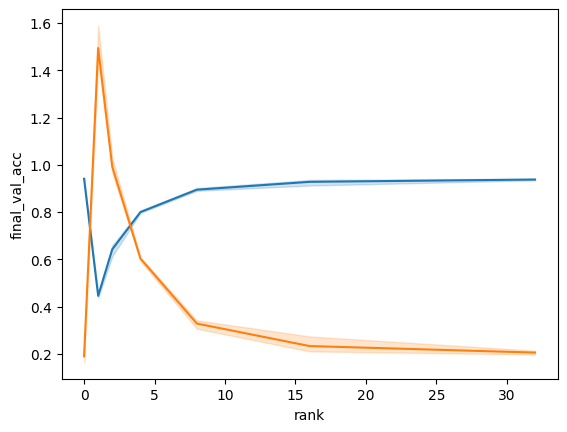

In [24]:
sns.lineplot(df, x="rank", y="final_val_acc")
sns.lineplot(df, x="rank", y="final_val_loss")
# sns.scatterplot(df, x="alpha", y="final_val_acc")